# Flight Data Analysis


In [1]:
%matplotlib inline
import os
import pymongo
import pandas as pd
db = pymongo.MongoClient(os.environ['MONGO_HOST'])['flirt']


In [2]:
import datetime
"Notebook evaluated on:" + str(datetime.datetime.now())


'Notebook evaluated on:2018-02-22 22:21:50.847126'

## Total Passenger Counts by Simulation


In [5]:
results = list(db.passengerFlows.aggregate([{
    '$group': {
        '_id': "$simGroup",
        'total': { '$sum': "$estimatedPassengers" }
    }
}]))
df = pd.DataFrame(results)
df


,_id,total
0,fmd-2018-01,3.194377e+08
1,fmd-2017-12,3.092283e+08
2,fmd-2017-03,3.171808e+08
3,fmd-2017-11,3.007377e+08
4,fmd-2017-07,3.520523e+08
5,stability-test-2,1.891600e+04
6,fmd-2018-02,2.970744e+08
7,fmd-2017-04,3.118833e+08
8,stability-test-1,1.891600e+04
9,ibis14day,3.194377e+08


In [6]:
results = list(db.schedules.aggregate([{
    "$group": {
        "_id": "$scheduleFileName",
        "minDate": { "$min": "$effectiveDate" }
    }
}]))
df = pd.DataFrame(results)
df


,_id,minDate
0,EcoHealth_20180109.csv,2018-01-08
1,EcoHealth-May2016_20170614.csv,2016-04-29
2,EcoHealth-Aug2016_20170614.csv,2016-07-29
3,EcoHealth_20170207.csv,2017-02-05
4,EcoHealth_20170509.csv,2017-05-08


In [7]:
results = list(db.importedFiles.find())
df = pd.DataFrame(results)
df


,_id,collection,importComplete,importFinishTime,importStartTime,importerVerion,name,parsedFileNameDate
0,5a5696996162005e50a7d767,schedules,True,2018-01-11 01:41:32.727,2018-01-10 22:41:29.706,0.0.0,/flirt-consume/data/EcoHealth-May2016_20170614...,2016-05-01
1,5a56c0cc6162005e50e6823a,schedules,True,2018-01-11 04:20:28.816,2018-01-11 01:41:32.736,0.0.0,/flirt-consume/data/EcoHealth-Aug2016_20170614...,2016-08-01
2,5a56e60c6162005e5027dc13,schedules,True,2018-01-11 07:07:58.638,2018-01-11 04:20:28.820,0.0.0,/flirt-consume/data/EcoHealth_20170207.csv,2017-02-07
3,5a570d4e6162005e506682a5,schedules,True,2018-01-11 09:42:40.675,2018-01-11 07:07:58.640,0.0.0,/flirt-consume/data/EcoHealth_20170509.csv,2017-05-09
4,5a5731906162005e50a5b586,schedules,True,2018-01-11 12:04:16.175,2018-01-11 09:42:40.690,0.0.0,/flirt-consume/data/EcoHealth_20180109.csv,2018-01-09
5,5a5792126162005e50e2be3c,flights,True,2018-01-11 16:57:47.594,2018-01-11 16:34:26.554,0.0.0,/flirt-consume/data/EcoHealth-May2016_20170614...,2016-05-01
6,5a57978b6162005e50e2f8e4,flights,True,2018-01-11 17:45:20.167,2018-01-11 16:57:47.598,0.0.0,/flirt-consume/data/EcoHealth-Aug2016_20170614...,2016-08-01
7,5a57a2b06162005e50e36de9,flights,True,2018-01-11 18:20:08.048,2018-01-11 17:45:20.170,0.0.0,/flirt-consume/data/EcoHealth_20170207.csv,2017-02-07
8,5a57aad86162005e50e3b110,flights,True,2018-01-11 19:11:58.246,2018-01-11 18:20:08.055,0.0.0,/flirt-consume/data/EcoHealth_20170509.csv,2017-05-09
9,5a57b6fe6162005e50e442d9,flights,True,2018-01-11 21:04:18.558,2018-01-11 19:11:58.252,0.0.0,/flirt-consume/data/EcoHealth_20180109.csv,2018-01-09


## Total domestic and international passenger arrivals by US airport

In [45]:
USAirports = [airport['_id'] for airport in db.airports.find({"countryName": "United States"})]
results = list(db.passengerFlows.aggregate([{
   "$match": {
       "simGroup": "fmd-2017-06",
       "arrivalAirport": {
           "$in": USAirports
       }
   }
}, {
    "$group": {
        "_id": "$arrivalAirport",
        "domestic": {
            "$sum": {
                "$cond": [{"$in": ["$departureAirport", USAirports]}, "$estimatedPassengers", 0]
            }
        },
        "domesticOrigins": {
            "$sum": {
                "$cond": [{"$in": ["$departureAirport", USAirports]}, 1, 0]
            }
        },
        "international": {
            "$sum": {
                "$cond": [{"$in": ["$departureAirport", USAirports]}, 0, "$estimatedPassengers"]
            }
        },
        "internationalOrigins": {
            "$sum": {
                "$cond": [{"$in": ["$departureAirport", USAirports]}, 0, 1]
            }
        },
        "passengerMiles": {
            "$sum": {
                "$multiply": ["$estimatedPassengers", "$averageDistance"]
            }
        }
    }
}]))
inbound_df = pd.DataFrame(results)
inbound_df['combined'] = inbound_df.domestic + inbound_df.international
inbound_df = inbound_df.sort_values(by='combined', ascending=False).set_index('_id')
inbound_df


,domestic,domesticOrigins,international,internationalOrigins,passengerMiles,combined
_id,,,,,,
LAX,2.162127e+06,487,1.661738e+06,1541,6.308983e+08,3.823866e+06
ATL,3.137071e+06,460,5.277444e+05,1135,3.023111e+08,3.664815e+06
ORD,2.269636e+06,464,7.981382e+05,1346,2.153622e+08,3.067774e+06
JFK,9.942788e+05,431,1.488094e+06,1791,2.753464e+08,2.482373e+06
DFW,1.905504e+06,465,4.909637e+05,950,1.563587e+08,2.396467e+06
SFO,1.433959e+06,483,8.635729e+05,1294,1.812484e+08,2.297532e+06
DEN,2.043535e+06,463,1.786764e+05,606,1.582895e+08,2.222212e+06
SEA,1.685189e+06,552,3.304563e+05,843,1.877283e+08,2.015645e+06
LAS,1.577941e+06,460,2.144170e+05,690,1.030910e+08,1.792358e+06


In [69]:
direct_incoming_df = pd.DataFrame(list(
 db.flights.aggregate([
    {
        '$match': {
            "$and": [{
                'departureDateTime': {
                    '$lte': datetime.datetime(2017, 7, 1)
                }
            }, {
                'departureDateTime': {
                    '$gte': datetime.datetime(2017, 6, 1)
                }
            }]
        }
    }, {
        '$group': {
            '_id': {
                '$concat': ['$departureAirport', '-', '$arrivalAirport']
            },
            'arrivalAirport': { '$first': '$arrivalAirport' },
            'departureAirport': { '$first': '$departureAirport' }
        }
    }, {
        '$group': {
            '_id': '$arrivalAirport',
            "directDomesticOrigins": {
                "$sum": {
                    "$cond": [{"$in": ["$departureAirport", USAirports]}, 1, 0]
                }
            },
            "directInternationalOrigins": {
                "$sum": {
                    "$cond": [{"$in": ["$departureAirport", USAirports]}, 0, 1]
                }
            }
        }
    }
  ])
)).set_index('_id')
direct_incoming_df

,directDomesticOrigins,directInternationalOrigins
_id,,
KKB,1,0
TXF,0,1
NIB,1,0
QBC,0,1
KOZ,1,0
BVH,0,1
GGG,1,0
KMU,0,1
EQS,0,1


In [35]:
import glob
# The BTS Market data shows more incoming origins than the direct flight data
# indicating that it includes multi-leg flights, however, it has few origins
# than the simulated data. The overall passenger counts are relatively close.
# This suggests that the simulations are causing passengers to fan out to
# more distinct locations than they do in reality.
# Source:
# https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=292
bts_df = pd.read_csv(glob.glob("*_T100_MARKET_ALL_CARRIER.csv")[0])
bts_df = bts_df.query("MONTH == 6")[["PASSENGERS", "ORIGIN", "DEST"]]
bts_df["domestic_origin"] = bts_df.ORIGIN.isin(USAirports)
bts_df["international_origin"] = ~bts_df.domestic_origin
bts_df["domestic_destination"] = bts_df.DEST.isin(USAirports)
bts_df["international_destination"] = ~bts_df.domestic_destination
bts_df["domestic_dest_passengers"] = bts_df.PASSENGERS * bts_df.domestic_destination
bts_df["international_dest_passengers"] = bts_df.PASSENGERS * bts_df.international_destination
bts_df["domestic_passengers"] = bts_df.PASSENGERS * bts_df.domestic_origin
bts_df["international_passengers"] = bts_df.PASSENGERS * bts_df.international_origin
t100_df = bts_df.groupby("ORIGIN").sum()

### Compare simulated outflows to BTS data

In [28]:
results = list(db.passengerFlows.aggregate([{
   "$match": {
       "simGroup": "fmd-2017-06",
       "departureAirport": {
           "$in": USAirports
       }
   }
}, {
    "$group": {
        "_id": "$departureAirport",
        "domesticPassengersSim": {
            "$sum": {
                "$cond": [{"$in": ["$arrivalAirport", USAirports]}, "$estimatedPassengers", 0]
            }
        },
        "internationalPassengersSim": {
            "$sum": {
                "$cond": [{"$in": ["$arrivalAirport", USAirports]}, 0, "$estimatedPassengers"]
            }
        },
    }
}]))

In [36]:
df = pd.DataFrame(results).set_index('_id')
df = df.join(t100_df)
df.sum()

domesticPassengersSim            5.461812e+07
internationalPassengersSim       1.382379e+07
PASSENGERS                       7.759208e+07
domestic_origin                  2.324300e+04
international_origin             0.000000e+00
domestic_destination             2.015600e+04
international_destination        3.087000e+03
domestic_dest_passengers         6.679463e+07
international_dest_passengers    1.079745e+07
domestic_passengers              7.759208e+07
international_passengers         0.000000e+00
dtype: float64

In [37]:
df['ratio'] = (df.domesticPassengersSim + df.internationalPassengersSim) / df.PASSENGERS
df.sort_values('ratio')

,domesticPassengersSim,internationalPassengersSim,PASSENGERS,domestic_origin,international_origin,domestic_destination,international_destination,domestic_dest_passengers,international_dest_passengers,domestic_passengers,international_passengers,ratio
_id,,,,,,,,,,,,
GCN,1.950000e+02,0.0000,10268.0,8.0,0.0,7.0,1.0,10267.0,1.0,10268.0,0.0,0.018991
PGA,1.950000e+02,0.0000,2530.0,11.0,0.0,10.0,1.0,2528.0,2.0,2530.0,0.0,0.077075
DUT,2.310000e+02,0.0000,2228.0,13.0,0.0,12.0,1.0,2088.0,140.0,2228.0,0.0,0.103680
CXF,1.330000e+02,0.0000,1208.0,8.0,0.0,8.0,0.0,1208.0,0.0,1208.0,0.0,0.110099
KWF,7.688450e+01,0.1155,469.0,3.0,0.0,3.0,0.0,469.0,0.0,469.0,0.0,0.164179
LKE,1.614189e+02,327.5811,2913.0,15.0,0.0,10.0,5.0,1609.0,1304.0,2913.0,0.0,0.167868
IFP,1.478504e+03,34.4964,7899.0,57.0,0.0,54.0,3.0,7693.0,206.0,7899.0,0.0,0.191543
SIG,3.294060e+02,538.5940,1933.0,9.0,0.0,5.0,4.0,1070.0,863.0,1933.0,0.0,0.449043
ROP,7.149747e+02,308.0253,1990.0,10.0,0.0,10.0,0.0,1990.0,0.0,1990.0,0.0,0.514070


### Compare Incoming passenger flows with BTS data

In [70]:
inbound_df.join(bts_df.groupby("DEST").sum()).rename(columns={
    "PASSENGERS": "Total Passengers (actual)",
    "domestic_passengers": "Domestic Passengers (actual)",
    "international_passengers": "International Passengers (actual)",
    "combined": "Total Passengers (simulated)",
    "domestic": "Domestic Passengers (simulated)",
    "international": "International Passengers (simulated)",
    "domestic_origin": "Number of Domestic Origins (actual)",
    "international_origin": "Number of International Origins (actual)"
}).join(direct_incoming_df)


,Domestic Passengers (simulated),domesticOrigins,International Passengers (simulated),internationalOrigins,passengerMiles,Total Passengers (simulated),Total Passengers (actual),Number of Domestic Origins (actual),Number of International Origins (actual),Domestic Passengers (actual),International Passengers (actual),directDomesticOrigins,directInternationalOrigins
_id,,,,,,,,,,,,,
LAX,2.162127e+06,487,1.661738e+06,1541,6.308983e+08,3.823866e+06,3668116.0,363.0,221.0,2608156.0,1059960.0,99,87
ATL,3.137071e+06,460,5.277444e+05,1135,3.023111e+08,3.664815e+06,4545965.0,435.0,120.0,3980164.0,565801.0,158,76
ORD,2.269636e+06,464,7.981382e+05,1346,2.153622e+08,3.067774e+06,3564249.0,569.0,150.0,2946242.0,618007.0,161,56
JFK,9.942788e+05,431,1.488094e+06,1791,2.753464e+08,2.482373e+06,2680268.0,180.0,240.0,1221302.0,1458966.0,66,112
DFW,1.905504e+06,465,4.909637e+05,950,1.563587e+08,2.396467e+06,2837672.0,366.0,98.0,2445461.0,392211.0,163,54
SFO,1.433959e+06,483,8.635729e+05,1294,1.812484e+08,2.297532e+06,2427191.0,227.0,99.0,1828948.0,598243.0,78,49
DEN,2.043535e+06,463,1.786764e+05,606,1.582895e+08,2.222212e+06,2766738.0,475.0,36.0,2646753.0,119985.0,149,20
SEA,1.685189e+06,552,3.304563e+05,843,1.877283e+08,2.015645e+06,2130933.0,297.0,55.0,1918731.0,212202.0,89,22
LAS,1.577941e+06,460,2.144170e+05,690,1.030910e+08,1.792358e+06,2007314.0,264.0,42.0,1859349.0,147965.0,113,19


In [ ]:
seatac_dest_oct_2016_rankings = [
    "LAX",
    "SFO",
    "ANC",
    "DEN",
    "LAS",
    "PHX",
    "ORD",
    "PDX",
    "DFW",
    "GEG"
]
results = list(db.passengerFlows.aggregate([{
   "$match": {
       "departureAirport": "SEA",
       "simGroup": {
           "$in": [
               "fmd-2017-03",
               "fmd-2017-04",
               "fmd-2017-05",
               "fmd-2017-06",
               "fmd-2017-07",
               "fmd-2017-08",
               "fmd-2017-09"
           ]
       },
       "arrivalAirport": {
           "$in": USAirports
       }
   }
}, {
    "$group": {
        "_id": "$arrivalAirport",
        "total": { "$sum": "$estimatedPassengers" }
    }
}]))
pd.DataFrame(results).sort_values(by="total", ascending=False)


In [71]:
# Num flights out vs in
out_counts_map = {}
departure_airports = set()
arrival_airprots = set()
for doc in db.flights.aggregate([{
    "$group": {
        "_id": "$departureAirport",
        "total": { "$sum": 1 }
    }
}]):
    departure_airports.add(doc['_id'])
    out_counts_map[doc['_id']] = doc['total']
ratios = []
for doc in db.flights.aggregate([{
    "$group": {
        "_id": "$arrivalAirport",
        "total": { "$sum": 1 }
    }
}]):
    arrival_airprots.add(doc['_id'])
    out_count = out_counts_map.get(doc['_id'], None)
    if out_count:
        ratios.append(dict(
            _id=doc['_id'],
            ratio=doc['total'] / out_count))
print("Inbound only airports", arrival_airprots - departure_airports)
print("Outbound only airports", departure_airports - arrival_airprots)
pd.DataFrame(ratios).sort_values(by="ratio")

In [ ]:
results = db.flights.aggregate([{
    "$group": {
        "_id": {
            "$concat": [{
                "$dateToString": {
                    "date": "$departureDateTime",
                    "format": "%Y-%m-%d",
                }
            }, "_", "$scheduleFileName"]
        },
        "totalFlights": { "$sum": 1 },
        "totalSeats": { "$sum": "$totalSeats" }
    }
}])
df = pd.DataFrame(list(results))
parsed_df = pd.concat([df._id.str.split('_', expand=True, n=1), df], axis=1).rename(
    columns={0: 'date', 1: 'file'})
parsed_df.date = pd.to_datetime(parsed_df.date)
parsed_df[["date", "totalFlights", "totalSeats", "file"]]
parsed_df


file        EcoHealth-Aug2016_20170614.csv  EcoHealth-May2016_20170614.csv  \
date                                                                         
2016-05-01                             NaN                      13162896.0   
2016-05-02                             NaN                      13949023.0   
2016-05-03                             NaN                      13577067.0   
2016-05-04                             NaN                      13634860.0   
2016-05-05                             NaN                      13700410.0   
2016-05-06                             NaN                      13917245.0   
2016-05-07                             NaN                      12924863.0   
2016-05-08                             NaN                      13364023.0   
2016-05-09                             NaN                      13982176.0   
2016-05-10                             NaN                      13626948.0   
2016-05-11                             NaN                      

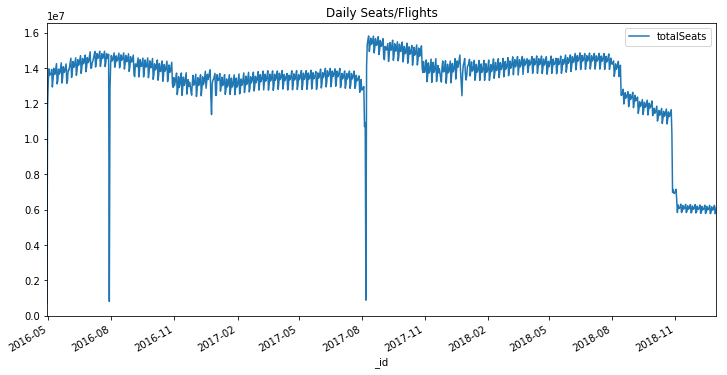

In [70]:
parsed_df[parsed_df.date < pd.Timestamp("2019-1-1")].plot(
    x="date",
    y="totalSeats",
    kind="line",
    title="Daily Seats",
    figsize=(12, 6))

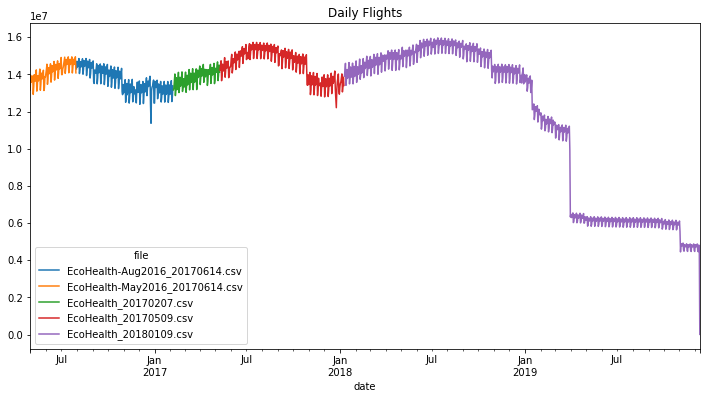

In [33]:
parsed_df.pivot(index='date', columns='file', values='totalSeats').reset_index().plot(
    x="date",
    kind="line",
    title="Daily Flights",
    figsize=(12, 6))
